In [18]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 6)

import utils

import importlib
importlib.reload(utils)

import os
import sys
import subprocess

In [19]:
train, test, info, index = utils.ReadData("debug3")

In [20]:
train.shape

(2000, 743)

In [21]:
# val = train.values[:, -60:]
# train_for_val = train.values[:, :-60]

val = test.values
train_for_val = train

## different mean

In [7]:
last_elements = [1,2,3,4,5,6,7,8,9,10,20,30,50,100,200,300,400,500]
scores = []
for i in last_elements:
    y_pred = np.tile(np.nanmean(train_for_val[:, -i:], axis=1), (60, 1)).T
    y_pred = np.nan_to_num(y_pred)
#     print(np.isnan(y_pred).sum())
    
    scores.append(np.nanmean(utils.SMAPE_score(val, y_pred, print_mean=False)))

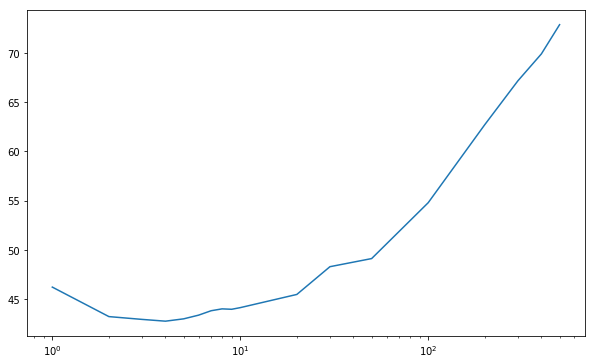

In [8]:
last_elements = np.array(last_elements)
scores = np.array(scores)
plt.xscale('log')
plt.plot(last_elements, scores)

In [9]:
np.min(scores)

42.751324

In [10]:
last_elements[np.argmin(scores)]

4

In [56]:
%%time
y_pred = np.tile(np.nanmean(train.values[:, -4:], axis=1), (60, 1)).T

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 10.8 ms


In [57]:
y_pred = np.nan_to_num(y_pred)
y_pred = np.round(y_pred)

In [58]:
utils.SaveModel("nanmean_on_last_4",
                y_pred, test,
                0.009, "no transformation",
                index.values.reshape(-1))

In [1]:
# pd.read_csv("../data/google_wtts/models/info.csv")

## Median

In [21]:
last_elements = list(range(1, 51, 5)) + [100,200,300,400,500]
scores = []
for i in last_elements:
    y_pred = np.tile(np.nanmedian(train_for_val[:, -i:], axis=1), (60, 1)).T
    y_pred = np.nan_to_num(y_pred)
#     print(np.isnan(y_pred).sum())
    
    scores.append(np.nanmean(utils.SMAPE_score(val, y_pred, print_mean=False)))

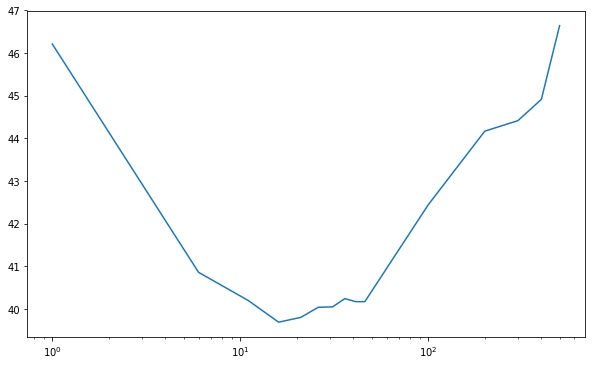

In [22]:
last_elements = np.array(last_elements)
scores = np.array(scores)
plt.xscale('log')
plt.plot(last_elements, scores)

In [23]:
np.min(scores)

39.685757

In [24]:
last_elements[np.argmin(scores)]

16

In [60]:
%%time
y_pred = np.tile(np.nanmedian(train.values[:, -last_elements[np.argmin(scores)]:], axis=1), (60, 1)).T

CPU times: user 212 ms, sys: 68 ms, total: 280 ms
Wall time: 1.04 s


In [61]:
y_pred = np.nan_to_num(y_pred)
y_pred = np.round(y_pred)

In [62]:
utils.SaveModel("nanmedian_on_last_16",
                y_pred, test,
                0.04, "no transformation",
                index.values.reshape(-1))

## weighted_median

In [22]:
def weighted_median(x, w=None):
    if w is None:
        w = np.ones_like(x)
    
    if x.ndim == 1:
        raise Exception("Pass 2-dimensional array. Use .reshape(1, -1)")
            
    assert(x.ndim == 2)
    assert(x.shape[-1] == w.shape[-1])
    
    if w.shape != x.shape:
        w = np.tile(w, (x.shape[0], 1))

    assert(w.shape == x.shape)
    
    
    #sorting x and w
    x_argsort = np.argsort(x)
    x = np.take_along_axis(x, x_argsort, axis=-1)
    w = np.take_along_axis(w, x_argsort, axis=-1)
    
    
    # now we want to look for 0.5...
    w = np.cumsum(w, axis=-1)
    w = (w.T / w[:, -1].T).T
    
    # this one is slow
    indices = np.array([
        np.searchsorted(w[i], 0.5, side='right') 
        for i in range(w.shape[0])
    ]).reshape((x.shape[0], 1))
    
    # finally take medians
    return np.take_along_axis(x, indices=indices, axis=1).reshape(1, -1)[0]


def create_exp_decay(n, last, q):
    w = np.zeros(n)
    w[-1] = last
    for i in range(len(w) - 2, -1, -1):
        w[i] = w[i+1] * q
        
    return w

In [23]:
w = create_exp_decay(train_for_val.shape[1], 100, 0.999)

In [29]:
predictions = weighted_median(train_for_val.values, w)

In [33]:
predictions.shape

(2000,)

In [34]:
predictions = np.tile(predictions.T, (60, 1)).T

In [35]:
predictions.shape

(2000, 60)

In [38]:
k = 8

In [ ]:
x_train = x_train[-lags:]
y_train = y_train[-lags:]
y_val = correction(y_val)
#     y_val = np.expm1(y_val)

plt.vlines(n, ymin=4, ymax=7, linestyles='--')
plt.plot(np.concatenate((x_train, x_val)),
         np.concatenate((log_train_for_val[i][-lags:], np.log1p(val[i]))))
plt.plot(x_train, y_train)
plt.plot(x_val, y_val, label='prediction')
plt.xlabel('days')
plt.ylabel('log')
plt.legend()
plt.title('Kalman filter with seasonality (no learn)')
plt.show()

In [45]:
alpha = [0.8, 0.83, 0.85, 0.87, 0.9, 0.92, 0.95,] #0.975, 0.99, 0.992, 0.994, 0.996, 0.999, 1
scores = []
for i in alpha:
    w = create_exp_decay(train_for_val.shape[1], 100, i)
    y_pred = weighted_median(train_for_val, w)
    y_pred = np.tile(y_pred, (60, 1)).T
    
    scores.append(np.nanmean(utils.SMAPE_score(val, y_pred, print_mean=True)))

SMAPE:  39.646408
SMAPE:  39.49782
SMAPE:  39.37607
SMAPE:  39.302227
SMAPE:  39.176323
SMAPE:  39.132717
SMAPE:  39.24933


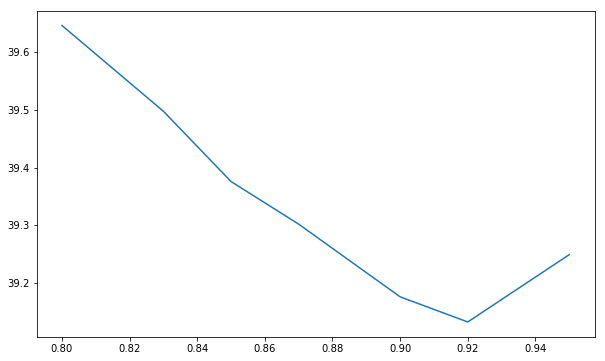

In [46]:
alpha = np.array(alpha)
scores = np.array(scores)
# plt.xscale('log')
plt.plot(alpha, scores)

In [63]:
w = create_exp_decay(train.shape[1], 100, 0.92)

In [64]:
#plt.plot(w[-100:])

In [65]:
w = create_exp_decay(train.shape[1], 100, 0.92)
%%time
y_pred = weighted_median(np.nan_to_num(train), w)

CPU times: user 9.32 s, sys: 3.12 s, total: 12.4 s
Wall time: 1min 5s


In [66]:
y_pred = np.tile(y_pred, (60, 1)).T
y_pred = np.nan_to_num(y_pred)
y_pred = np.round(y_pred)

In [67]:
utils.SaveModel("weighted_median_092_decay",
                y_pred, test,
                10, "no transformation",
                index.values.reshape(-1))

## Last elem

In [68]:
y_pred = train.values[:, -1]
y_pred = np.tile(y_pred, (60, 1)).T
y_pred = np.nan_to_num(y_pred)

In [69]:
utils.SaveModel("last_elem",
                y_pred, test,
                0, "no transformation",
                index.values.reshape(-1))

## median with day of the weeks 

In [70]:
def median_for_each_day(train_df, last_weeks):
    start = (train_df.shape[1] % 7)
    train_df = np.nan_to_num(train_df)
    seven_days = []
    for i in range(7):
        seven_days.append(np.median(train_df[:, (start+i)::7][:, -last_weeks:], axis=1))

    seven_days = np.array(seven_days)
    seven_days = np.tile(seven_days, (9, 1)).T
    seven_days = seven_days[:, :60]

    return seven_days

In [71]:
last_elements = [1,2,3,4,5,6,7,8,9,10]
scores = []
for i in last_elements:
    y_pred = median_for_each_day(train_for_val, i)
    y_pred = np.nan_to_num(y_pred)
    scores.append(np.nanmean(utils.SMAPE_score(val, y_pred, print_mean=False)))

In [75]:
scores = np.array(scores)

In [76]:
%%time
y_pred = median_for_each_day(train, last_elements[np.argmin(scores)])

CPU times: user 744 ms, sys: 584 ms, total: 1.33 s
Wall time: 5.81 s


In [77]:
y_pred = np.nan_to_num(y_pred)
y_pred = np.round(y_pred)

In [78]:
utils.SaveModel("median_daily_last_7_weeks",
                y_pred, test,
                1.2, 
                "no transformation",
                index.values.reshape(-1))

## weighted median with days of week

In [79]:
start = (train_for_val.shape[1] % 7)
train_df = np.nan_to_num(train_for_val)
seven_days = []

In [80]:
def median_for_each_day_weighted(train_df, alpha):
    start = (train_df.shape[1] % 7)
    train_df = np.nan_to_num(train_df)
    seven_days = []
    
    
    for i in range(7):
        cur_train  = train_df[:, (start+i)::7]
        w = create_exp_decay(cur_train.shape[1], 100, alpha)
        y_pred = weighted_median(cur_train, w)
        seven_days.append(y_pred)


    seven_days = np.array(seven_days)
    seven_days = np.tile(seven_days, (9, 1)).T
    seven_days = seven_days[:, :60]

    return seven_days

In [81]:
last_elements = [0.8, 0.85, 0.9, 0.92, 0.95, 0.97]
scores = []
for i in last_elements:
    y_pred = median_for_each_day_weighted(train_for_val, i)
    y_pred = np.nan_to_num(y_pred)
    
    scores.append(np.nanmean(utils.SMAPE_score(val, y_pred, print_mean=False)))

In [82]:
scores

[39.70568, 39.815113, 40.220356, 40.521564, 41.217945, 42.483223]

In [85]:
last_elements = [0.75, 0.78, 0.82, 0.84]
scores = []
for i in last_elements:
    y_pred = median_for_each_day_weighted(train_for_val, i)
    y_pred = np.nan_to_num(y_pred)
    
    scores.append(np.nanmean(utils.SMAPE_score(val, y_pred, print_mean=False)))

In [87]:
scores

[39.813553, 39.702396, 39.724403, 39.74205]

In [92]:
%%time
y_pred = median_for_each_day_weighted(train, 0.8)

CPU times: user 9.19 s, sys: 2.46 s, total: 11.7 s
Wall time: 11.7 s


In [93]:
y_pred = np.nan_to_num(y_pred)
y_pred = np.round(y_pred)

In [94]:
utils.SaveModel("median_daily_weighted_0.8",
                y_pred, test,
                11, 
                "no transformation",
                index.values.reshape(-1))

## Neural network

In [113]:
y_pred = np.load("../data/google_wtts/models/lstm/predictions.npy")

In [105]:
y_pred = np.nan_to_num(y_pred)
y_pred = np.round(y_pred)

In [106]:
utils.SaveModel("lstm_3_layers_skip_coonections",
                y_pred, test,
                -1, 
                "1 hours, 2 gpu K 80",
                index.values.reshape(-1))

## NN + medians

In [ ]:
y_pred = np.load("../data/google_wtts/models/lstm/predictions.npy")

In [114]:
w = create_exp_decay(train.shape[1], 100, 0.92)
medians = weighted_median(np.nan_to_num(train), w)

In [115]:
medians = np.tile(medians, (60, 1)).T

In [117]:
y_pred = (medians + y_pred) / 2

In [118]:
y_pred = np.nan_to_num(y_pred)
y_pred = np.round(y_pred)

In [119]:
utils.SaveModel("medians+lstm",
                y_pred, test,
                -1, 
                "1 hours, 2 gpu K 80",
                index.values.reshape(-1))

## Check

In [122]:
info = pd.read_csv("../data/google_wtts/models/info.csv", index_col="row_names")

In [123]:
info

,nanmean_on_last_4,nanmedian_on_last_16,weighted_median_092_decay,last_elem,median_daily_last_7_weeks,median_daily_weighted_0.8,lstm_3_layers_skip_coonections,medians+lstm,holt_winters
row_names,,,,,,,,,
SMAPE_full,44.098534,41.988926,41.123295,47.084824,43.167763,42.019257,41.612988,40.42778,NaN
SMAPE_debug,45.42543,43.83707,43.099163,47.784195,45.236904,44.03532,43.491608,42.200706,53.016304
SMAPE_zeros,83.7153,79.893036,80.095436,89.68031,83.85385,83.73489,81.80186,79.45347,87.6535616672039
SMAPE_weekly,32.6446,32.814365,31.780184,33.20075,33.254898,31.605772,32.77792,30.822918,42.27147364711762
RMLSE_full,0.55380636,0.53083414,0.52150863,0.58512735,0.5425241,0.5287815,0.52981913,0.5148989,NaN
RMLSE_debug,0.53508455,0.519535,0.51124924,0.5644635,0.5290962,0.5144787,0.5151975,0.5011223,0.65435857
RMLSE_zeros,0.59686714,0.5654197,0.5635631,0.6525946,0.59278333,0.59011155,0.5789559,0.5602295,0.638990854844451
RMLSE_weekly,0.4483793,0.44917005,0.43894243,0.45926854,0.4388889,0.41996613,0.44525415,0.42434973,0.6091672253608703
MASE_full,5.899013,5.7290063,5.6412034,5.9110494,5.8820434,5.7707124,5.624676,5.5887346,NaN
